In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf 

import phik
from phik.report import plot_correlation_matrix
from phik import report

from sklearn.linear_model import LinearRegression
from sklearn.compose

from sklearn.model_selection import (
    GridSearchCV,
    train_test_split,
    TimeSeriesSplit
)

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

SEED = 42

In [2]:
UX = pd.read_csv('/Users/egor/Desktop/uranium_project/PURANUSDM.csv') # Uranium Price
fed_rate = pd.read_csv('/Users/egor/Desktop/uranium_project/FEDFUNDS.csv') # Fed Rate
brent = pd.read_csv('/Users/egor/Desktop/uranium_project/POILBREUSDM.csv') # Oil
coal = pd.read_csv('/Users/egor/Desktop/uranium_project/PCOALAUUSDM.csv') # Coal
cpi_cum = pd.read_csv('/Users/egor/Desktop/uranium_project/CPIAUCSL.csv') # CPI

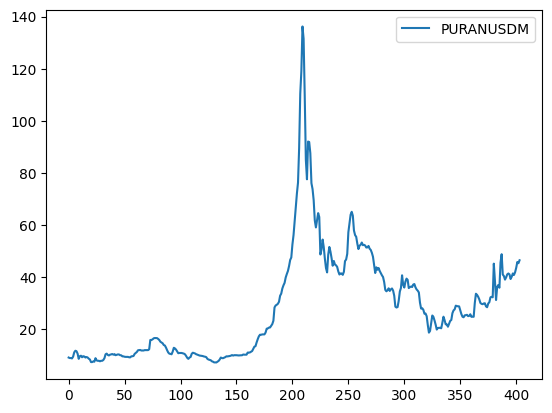

In [3]:
sns.lineplot(data=UX);

In [4]:
coal

,DATE,PCOALAUUSDM
0,1990-01-01,38.000000
1,1990-02-01,38.000000
2,1990-03-01,38.000000
3,1990-04-01,38.000000
4,1990-05-01,40.500000
...,...,...
399,2023-04-01,200.676190
400,2023-05-01,179.262321
401,2023-06-01,138.631656
402,2023-07-01,141.029592


In [5]:

ticker_symbol = "DX-Y.NYB"  

ticker = yf.Ticker(ticker_symbol)

start_date = "1990-01-01"
end_date = "2023-08-31"

historical_data = ticker.history(start=start_date, end=end_date, interval="1mo")

usd_index = historical_data['Close'] # USD Index

usd_index.index = pd.to_datetime(usd_index.index)


In [6]:
gld = "GC=F"  

ticker_gld = yf.Ticker(gld)

start_date = "1990-01-01"
end_date = "2023-08-31"
    
historical_data_gold = ticker_gld.history(start=start_date, end=end_date, interval="1mo")

gold = historical_data_gold['Close'] # Gold

gold.index = pd.to_datetime(gold.index)

gold


Date
2000-09-01 00:00:00-04:00     273.600006
2000-11-01 00:00:00-05:00     270.100006
2000-12-01 00:00:00-05:00     272.000000
2001-01-01 00:00:00-05:00     265.600006
2001-02-01 00:00:00-05:00     266.799988
                                ...     
2023-04-01 00:00:00-04:00    1990.099976
2023-05-01 00:00:00-04:00    1963.900024
2023-06-01 00:00:00-04:00    1921.099976
2023-07-01 00:00:00-04:00    1970.500000
2023-08-01 00:00:00-04:00    1938.199951
Name: Close, Length: 236, dtype: float64

In [7]:
slv = "EURUSD=X"  

ticker_slv = yf.Ticker(slv)
    
historical_data_slv = ticker_slv.history(start=start_date, end=end_date, interval="1mo")

silver = historical_data_slv['Close'] # Silver

silver.index = pd.to_datetime(silver.index)

silver



Date
2003-12-01 00:00:00+00:00    1.259002
2004-01-01 00:00:00+00:00    1.245206
2004-02-01 00:00:00+00:00    1.253007
2004-03-01 00:00:00+00:00    1.231300
2004-04-01 00:00:00+01:00    1.198294
                               ...   
2023-04-01 00:00:00+01:00    1.112842
2023-05-01 00:00:00+01:00    1.073307
2023-06-01 00:00:00+01:00    1.086803
2023-07-01 00:00:00+01:00    1.102426
2023-08-01 00:00:00+01:00    1.093255
Name: Close, Length: 237, dtype: float64

In [8]:
spx = "^SPX"  

ticker_spx = yf.Ticker(spx)
    
historical_data_spx = ticker_spx.history(start=start_date, end=end_date, interval="1mo")

sp_500 = historical_data_spx['Close'] # SP 500 Index

sp_500.index = pd.to_datetime(sp_500.index)

sp_500 = pd.DataFrame(sp_500)

sp_500 = sp_500.rename(columns={'Close': 'sp_500'})




In [9]:
df = (
    UX.merge(fed_rate, on = "DATE")
    .merge(brent, on = "DATE")
    .merge(coal, on = "DATE")
    .merge(cpi_cum, on = "DATE")
    .merge(usd_index, on = usd_index.index)
)

col_names = {
    'DATE': 'date',
    'PURANUSDM': 'uranium',
    'FEDFUNDS': 'fed_rate',
    'POILBREUSDM': 'brent',
    'PCOALAUUSDM': 'coal',
    'CPIAUCSL': 'cpi',
    'Close': 'usd_index',
}

df = df.rename(columns=col_names)

df['date'] = pd.to_datetime(df['date'])

del df['key_0']

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404 entries, 0 to 403
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       404 non-null    datetime64[ns]
 1   uranium    404 non-null    float64       
 2   fed_rate   404 non-null    float64       
 3   brent      404 non-null    float64       
 4   coal       404 non-null    float64       
 5   cpi        404 non-null    float64       
 6   usd_index  404 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 22.2 KB


In [10]:
df = df.merge(sp_500, on = sp_500.index)

del df['key_0']

In [11]:
corr_matrix = df.drop(['date'], axis =1).copy().phik_matrix()
corr_matrix.round(2)

mask = np.triu(np.ones_like(corr_matrix.round(2), dtype=bool))
f, ax = plt.subplots(figsize=(25, 12), dpi = 800)

sns.heatmap(
    corr_matrix.round(2), 
    center=-0.07, 
    cmap="coolwarm", 
    square=True,
    linewidth=0.5, 
    cbar_kws={"shrink": .5}, 
    annot=True, 
    mask=mask
)
ax.set_title('Correlation Matrix');

interval columns not set, guessing: ['uranium', 'fed_rate', 'brent', 'coal', 'cpi', 'usd_index', 'sp_500']


In [12]:
train, test = train_test_split(
    df,
    shuffle = False,
    test_size = 0.1,
    random_state = SEED
)

X_train = train.drop(['date', 'uranium'], axis = 1).copy()
y_train = train['uranium'].copy()

X_test = test.drop(['date', 'uranium'], axis = 1).copy()
y_test = test['uranium'].copy()

In [13]:
model_1 = LinearRegression()

model_1.fit(X_train, y_train)

preds_1 = model_1.predict(X_test)

score_1 = mean_squared_error(y_test, preds_1)
score_1


907.8512050300379

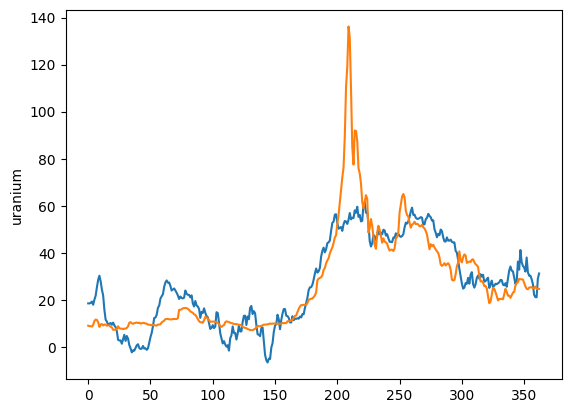

In [14]:
sns.lineplot(data=model_1.predict(X_train))
sns.lineplot(data=y_train);

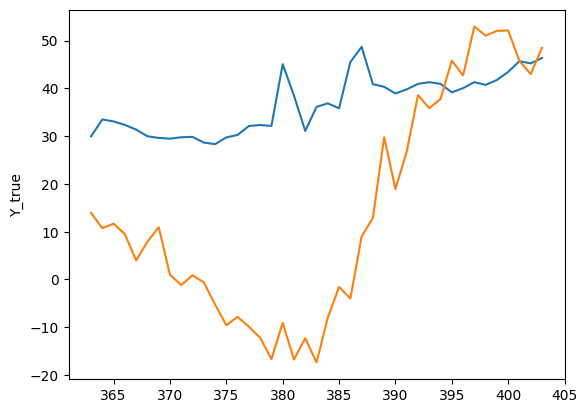

In [15]:
lr_test_data = pd.DataFrame(
    {
        'Y_true': y_test,
        'Y_preds': preds_1
    }
)

sns.lineplot(data=lr_test_data.Y_true)
sns.lineplot(data=lr_test_data.Y_preds);

array([ 6.10309425,  0.12962129, -0.0331825 ,  1.03381805, -0.40385771,
       -0.03280931])

In [16]:
uran = pd.read_csv('/Users/egor/Desktop/uranium_project/PURANUSDM.csv')
uran = uran.rename(
   columns={
    'DATE': 'date',
    'PURANUSDM': 'price'
   }
)
uran['ma_3'] = uran['price'].rolling(window=3).mean()
uran['ma_9'] = uran['price'].rolling(window=9).mean()

uran = uran.dropna()

uran

,date,price,ma_3,ma_9
8,1990-09-01,10.500000,11.183333,9.905556
9,1990-10-01,8.500000,10.150000,9.850000
10,1990-11-01,9.500000,9.500000,9.927778
11,1990-12-01,9.700000,9.233333,10.027778
12,1991-01-01,9.100000,9.433333,10.077778
...,...,...,...,...
399,2023-04-01,41.762017,41.272637,40.674435
400,2023-05-01,43.462666,41.988736,41.081142
401,2023-06-01,45.700483,43.641722,41.608930
402,2023-07-01,45.247534,44.803561,42.047145


In [17]:
train_ma, test_ma = train_test_split(
    uran,
    shuffle = False,
    test_size = 0.1,
    random_state = SEED
)

X_train_ma = train_ma.drop(['date', 'price'], axis = 1).copy()
y_train_ma = train_ma['price'].copy()

X_test_ma = test_ma.drop(['date', 'price'], axis = 1).copy()
y_test_ma = test_ma['price'].copy()

In [18]:
model_2 = LinearRegression()
model_2.fit(X_train_ma, y_train_ma)

LinearRegression()

In [19]:
preds_ma = model_2.predict(X_test_ma)

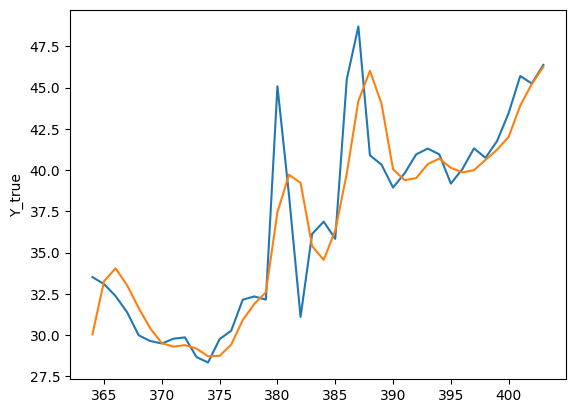

In [20]:
lr_test_data_ma = pd.DataFrame(
    {
        'Y_true': y_test_ma,
        'Y_preds': preds_ma
    }
)

sns.lineplot(data=lr_test_data_ma.Y_true)
sns.lineplot(data=lr_test_data_ma.Y_preds);

In [21]:
nucl = pd.read_csv('/Users/egor/Desktop/uranium_project/nuclear-energy-generation.csv')
nucl

,Entity,Code,Year,Electricity from nuclear (TWh)
0,ASEAN (Ember),NaN,2000,0.0
1,ASEAN (Ember),NaN,2001,0.0
2,ASEAN (Ember),NaN,2002,0.0
3,ASEAN (Ember),NaN,2003,0.0
4,ASEAN (Ember),NaN,2004,0.0
...,...,...,...,...
9566,Zimbabwe,ZWE,2018,0.0
9567,Zimbabwe,ZWE,2019,0.0
9568,Zimbabwe,ZWE,2020,0.0
9569,Zimbabwe,ZWE,2021,0.0
